In [98]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [99]:
#F0 function for use in integrals
def F_zero(t):
    t += 0.000001  #Prevents division by zero errors
    return (1/2) * (np.pi/t)**(1/2) * math.erf(t**(1/2)) #Makes use of error function

#Overlap integral
def S_integral(A, B, Rab2):
    return ((np.pi / (A + B)))**(3/2) * np.exp((-A * B * Rab2) / (A + B))

#Kinetic integral
def T_integral(A, B, Rab2):
    return A * B / (A + B) * (3.0 - 2.0 * A * B * Rab2 / (A + B)) * (np.pi / (A + B))**(3/2) * np.exp(-A * B * Rab2 / (A + B))

#Nuclear attraction integral
def V_integral(A, B, Rab2, Rpc2, Zc):
    return -2 * np.pi / (A + B) * Zc * np.exp((-A * B)/(A + B) * Rab2) * F_zero((A + B) * Rpc2)

#Two electron integral
def two_electron_integral(A, B, C, D, Rab2, Rcd2, Rpq2):
    return 2 * (np.pi**(5/2))/((A + B)*(C + D) * np.sqrt(A + B + C + D)) * F_zero((A + B) * (C + D) * Rpq2/(A + B + C + D)) * np.exp(-A * B * Rab2 / (A + B) - C * D * Rcd2 / (C + D))

In [100]:
def Calculate(R):
    #Initialise exponents and coefficients as given in the book
    alpha = np.array([0.168856, 0.623913, 3.42525])
    coeff = np.array([0.444635, 0.535328, 0.154329])

    #Scale coefficients
    for i in range(len(coeff)):
        coeff[i] = coeff[i] * ((2*alpha[i])/np.pi)**(3/4)

    #Initialise matrix elements
    S12 = 0
    T11 = 0
    T12 = 0
    V11_1 = 0
    V22_1 = 0
    V12_1 = 0
    V11_2 = 0
    V22_2 = 0
    V12_2 = 0
    V1111 = 0
    V2111 = 0
    V2121 = 0
    V2211 = 0
    V2221 = 0
    V2222 = 0

    #Calculate 1 electron integrals
    for i in range(len(coeff)):
        for j in range(len(coeff)):
            Rap = alpha[j]* R / (alpha[i] + alpha[j])

            S12 += coeff[i] * coeff[j] * S_integral(alpha[i], alpha[j], R**2)
            T11 += coeff[i] * coeff[j] * T_integral(alpha[i], alpha[j], 0)
            T12 += coeff[i] * coeff[j] * T_integral(alpha[i], alpha[j], R**2)
            V11_1 += coeff[i] * coeff[j] * V_integral(alpha[i], alpha[j], 0, 0, 1)
            V22_1 += coeff[i] * coeff[j] * V_integral(alpha[i], alpha[j], 0, R**2, 1)
            V12_1 += coeff[i] * coeff[j] * V_integral(alpha[i], alpha[j], R**2, Rap**2, 1)

    #Calculate 2 electron integrals
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    Rap = alpha[i] * R / (alpha[i] + alpha[j])
                    Rbp = R - Rap
                    Raq = alpha[k] * R / (alpha[k] + alpha[l])
                    Rpq = Rap - Raq

                    V1111 += coeff[i] * coeff[j] * coeff[k] * coeff[l] * two_electron_integral(alpha[i], alpha[j], alpha[k], alpha[l], 0, 0, 0)
                    V2111 += coeff[i] * coeff[j] * coeff[k] * coeff[l] * two_electron_integral(alpha[i], alpha[j], alpha[k], alpha[l], R**2, 0, Rap**2)
                    V2121 += coeff[i] * coeff[j] * coeff[k] * coeff[l] * two_electron_integral(alpha[i], alpha[j], alpha[k], alpha[l], R**2, R**2, Rpq**2)
                    V2211 += coeff[i] * coeff[j] * coeff[k] * coeff[l] * two_electron_integral(alpha[i], alpha[j], alpha[k], alpha[l], 0, 0, R**2)

    #Only 4 unique values for H2
    V2221 = V2111
    V2222 = V1111

    #Initialise matricies
    S = np.zeros((2, 2))
    T = np.zeros((2, 2))
    V_1 = np.zeros((2, 2))
    TT = np.zeros((2, 2, 2, 2))

    #Construct matricies
    for i in range(2):
        for j in range(2):
            S[i][j] = S12 if i != j else 1
            T[i][j] = T12 if i != j else T11
            V_1[i][j] = V12_1 if i != j else (V11_1 if i == 0 else V22_1)

    #Transform S into X
    X = np.zeros((2, 2))
    X[0, 0] = 1 / np.sqrt(2 * (1 + S12))
    X[1, 0] = X[0, 0]
    X[0, 1] = 1 / np.sqrt(2 * (1 - S12))
    X[1, 1] = -X[0, 1]

    #Nuclear attraction integral 2 is the same as 1 with diagonal elements swapped
    V_2 = np.copy(V_1)
    V_2[0][0], V_2[1][1] = V_1[1][1], V_1[0][0]

    #Construct coulomb and exchange matrix
    TT[0, 0, 0, 0] = V1111
    TT[1, 0, 0, 0] = V2111
    TT[0, 1, 0, 0] = V2111
    TT[0, 0, 1, 0] = V2111
    TT[0, 0, 0, 1] = V2111
    TT[1, 0, 1, 0] = V2121
    TT[0, 1, 1, 0] = V2121
    TT[1, 0, 0, 1] = V2121
    TT[0, 1, 0, 1] = V2121
    TT[1, 1, 0, 0] = V2211
    TT[0, 0, 1, 1] = V2211
    TT[1, 1, 1, 0] = V2221
    TT[1, 1, 0, 1] = V2221
    TT[1, 0, 1, 1] = V2221
    TT[0, 1, 1, 1] = V2221
    TT[1, 1, 1, 1] = V2222
    
    #Form core Hamiltonian
    H_core = T + V_1 + V_2

    return S, T, V_1, V_2, TT, H_core, X

In [101]:

def SCF(S, T, V_1, V_2, TT, H_core, X, R):

    MAXITER = 1000 #Maximum number of iterations for the SCF procedure
    CONV = 1e-10 #Convergence criteria
    ITER = 0 #Starting iteration

    #Guess initial density matrix
    P = np.zeros((2, 2))
    
    while ITER < MAXITER:
        ITER += 1

        #Form G 
        G = np.zeros((2, 2))

        for i in range(2):
            for j in range(2):
                for k in range(2):
                    for l in range(2):
                        G[i, j] += P[k, l] * (TT[i, j, k, l] - 0.5 * TT[i, l, k, j])

        #Form Fock matrix
        F = H_core + G

        #Calculate electronic energy
        e_energy = np.sum(0.5 * P * (H_core + F))

        #Form F' via a similarity transformation
        G = np.matmul(F, X)
        F_prime = np.matmul(X.T, G)

        #Diagonalise F' to get eigenvalues and coefficient matrix
        F_prime_eigval, C_prime = np.linalg.eigh(F_prime)
        E = np.diag(F_prime_eigval)

        #Transform coefficient matrix to obtain C
        C = np.matmul(X, C_prime)

        #Store old density matrix and form the new
        P_old = np.array(P)
        P = np.zeros((2, 2))
        for i in range(2):
            for j in range(2):
                for k in range(1):
                    P[i, j] += 2 * C[i, k] * C[j, k]

        #Compare density matricies
        DELTA = (P - P_old)
        DELTA = np.sqrt(np.sum(DELTA**2) / 4)

        #Verify convergence (or not)
        if DELTA < CONV:
            TotalE = e_energy + 1 * 1 / R #Total energy is electronic energy + nuclear repulsion
            print('Electronic Energy for R = {}: {}'.format(R, e_energy))
            print('Total Energy for R = {}: {}'.format(R, TotalE))
            print('\n')
            break

    return TotalE

Electronic Energy for R = 0.5: -2.40332603499135
Total Energy for R = 0.5: -0.4033260349913501


Electronic Energy for R = 0.505: -2.3999621832573093
Total Energy for R = 0.505: -0.4197641634553291


Electronic Energy for R = 0.51: -2.3965902107860892
Total Energy for R = 0.51: -0.43580589706059913


Electronic Energy for R = 0.515: -2.3932105138510655
Total Energy for R = 0.515: -0.45146294103553153


Electronic Energy for R = 0.52: -2.3898234815010877
Total Energy for R = 0.52: -0.4667465584241648


Electronic Energy for R = 0.525: -2.3864294955418024
Total Energy for R = 0.525: -0.48166759077989774


Electronic Energy for R = 0.53: -2.3830289305232135
Total Energy for R = 0.53: -0.49623647769302504


Electronic Energy for R = 0.535: -2.379622153733351
Total Energy for R = 0.535: -0.510463275228678


Electronic Energy for R = 0.54: -2.3762095251978836
Total Energy for R = 0.54: -0.524357673346032


Electronic Energy for R = 0.545: -2.3727913976855293
Total Energy for R = 0.545: -0.53

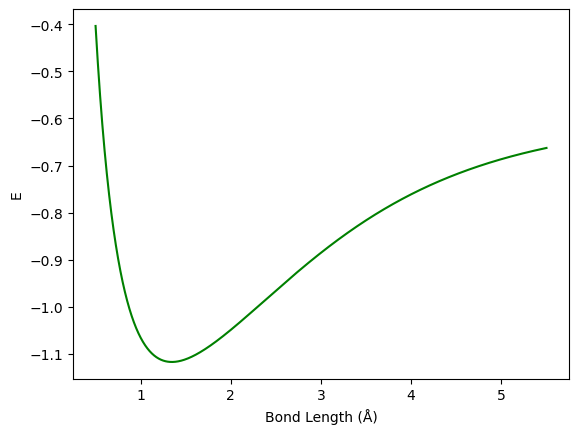

In [103]:
# Iterate over a series of bond lengths
bond_lengths = np.linspace(0.5, 5.5, 1001)
energies = []

for R in bond_lengths:
    S, T, V_1, V_2, TT, H_core, X = Calculate(R)
    energy = SCF(S, T, V_1, V_2, TT, H_core, X, R)
    energies.append(energy)

#Plotting
plt.plot(bond_lengths, energies, c = 'g')
plt.xlabel('Bond Length (Å)')
plt.ylabel('E')
plt.show()